## Amazon product co-purchasing network

Source: [SNAP-Stanford](https://snap.stanford.edu/data/com-Amazon.html)

Dataset statistics:

- Nodes: 334863
- Edges: 925872
- Nodes in the largest WCC: 334863 (1.000)
- Edges in the largest WCC: 925872 (1.000)
- Average clustering coefficient: 0.3967
- Number of triangles: 667129
- Fraction of closed triangles: 0.07925
- Diameter: 44
- 90-percentile effective diameter: 15

In [1]:
import networkx as nx
import numpy as np
import pylab as pl
import scipy as sp
import time
import random
import queue
from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline

# Data location
raw_data_loc = '../data/raw/amazon_copurchasing/'
data_loc = '../ data/amazon_copurchasing/'
raw_graph_file = raw_data_loc + 'com-amazon.ungraph.txt'
raw_com_file = raw_data_loc + 'com-amazon.all.dedup.cmty.txt'
top5k_com_file = raw_data_loc + 'com-amazon.top5000.cmty.txt'

## Load graph

NetworkX is used to load the graph from the ```raw_graph_file``` and check for basic metrics (statistics).

In [2]:
g = nx.read_edgelist(raw_graph_file)

In [3]:
N, K = g.order(), g.size()
avg_deg = K / N

print("Number of nodes: ", N)
print("Number of edges: ", K)
print("Average degree: ", avg_deg)

Number of nodes:  334863
Number of edges:  925872
Average degree:  2.7649277465709856


## Degree distribution

In [4]:
degrees = g.degree()
degrees_vals = sorted(set(degrees.values()))
hist = [list(degrees.values()).count(v) for v in degrees_vals]

(0, 200)

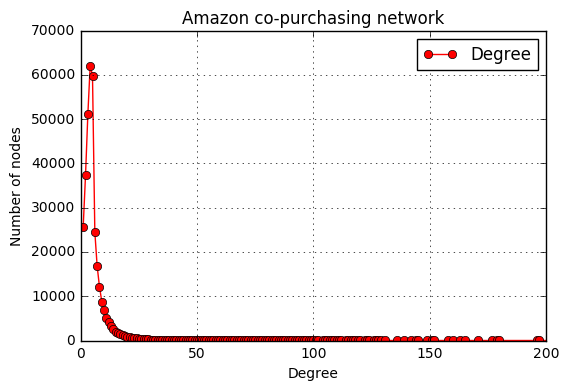

In [5]:
plt.figure()
plt.grid(True)
plt.plot(degrees_vals, hist, 'ro-')
plt.legend(['Degree'])
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Amazon co-purchasing network')
plt.xlim([0, 2*10**2])

(1.0, 200)

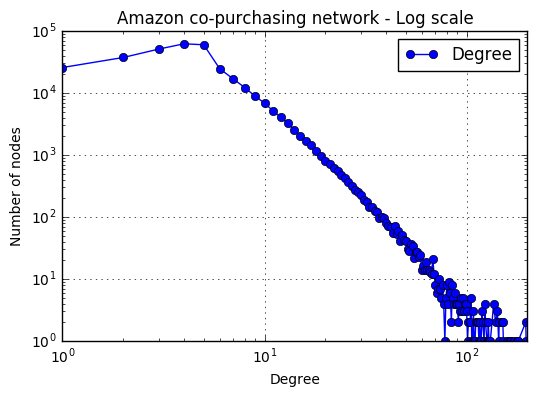

In [6]:
plt.figure()
plt.grid(True)
plt.loglog(degrees_vals, hist, 'bo-')
plt.legend(['Degree'])
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Amazon co-purchasing network - Log scale')
plt.xlim([0, 2*10**2])

Testing the code for fitting function in scipy. Check back later at [Cookbook Scipy](http://scipy.github.io/old-wiki/pages/Cookbook/FittingData#CA-029e9ae12c0592e5c90cf64b2b75493a82c5351b_12).

In [7]:
num_points = 150
Tx = sp.linspace(5., 8., num_points)
Ty = Tx

tX = 11.86 * sp.cos(2*sp.pi/0.81*Tx-1.32) + \
     0.64 * Tx + 4 * ((0.5 -sp.rand(num_points)) * \
                     sp.exp(2*sp.rand(num_points)**2))
tY = tY = -32.14*sp.cos(2*sp.pi/0.8*Ty-1.94) + 0.15*Ty+7* \
          ((0.5-sp.rand(num_points))*sp.exp(2*sp.rand(num_points)**2))

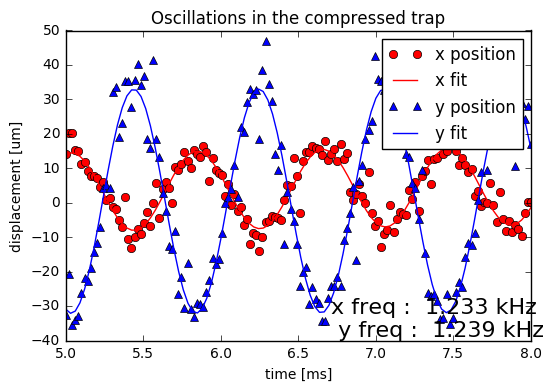

In [8]:
# Fit the first set
fitfunc = lambda p, x: p[0]*sp.cos(2*sp.pi/p[1]*x+p[2]) + p[3]*x # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
p0 = [-15., 0.8, 0., -1.] # Initial guess for the parameters
p1, success = sp.optimize.leastsq(errfunc, p0[:], args=(Tx, tX))

time = sp.linspace(Tx.min(), Tx.max(), 100)
plt.plot(Tx, tX, "ro", time, fitfunc(p1, time), "r-") # Plot of the data and the fit

# Fit the second set
p0 = [-15., 0.8, 0., -1.]
p2,success = sp.optimize.leastsq(errfunc, p0[:], args=(Ty, tY))

time = sp.linspace(Ty.min(), Ty.max(), 100)
plt.plot(Ty, tY, "b^", time, fitfunc(p2, time), "b-")

# Legend the plot
plt.title("Oscillations in the compressed trap")
plt.xlabel("time [ms]")
plt.ylabel("displacement [um]")
plt.legend(('x position', 'x fit', 'y position', 'y fit'))

ax = plt.axes()

plt.text(0.8, 0.07,
     'x freq :  %.3f kHz \n y freq :  %.3f kHz' % (1/p1[1],1/p2[1]),
     fontsize=16,
     horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes)

(0, 200)

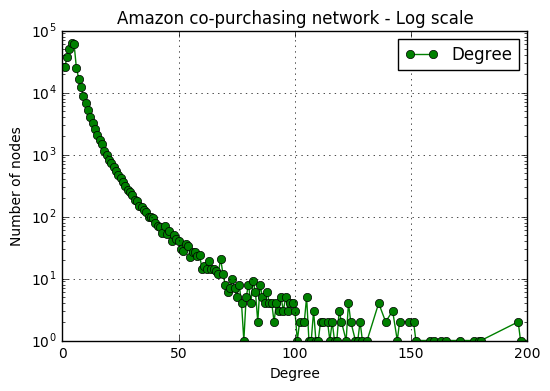

In [9]:
plt.figure()
plt.grid(True)
plt.semilogy(degrees_vals, hist, 'go-')
plt.legend(['Degree'])
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Amazon co-purchasing network - Log scale')
plt.xlim([0, 2*10**2])

From the log-log plot (blue), we can be almost certain that the degree distribution of this Amazon network follows the power law.

## Clustering coefficient

Clustering coeffient only works on undirected graph. We can get the clustering coeffient for all the nodes  or single node:

In [10]:
print('Clustering coefficient of node 1:')
print(nx.clustering(g, ['1']))

Clustering coefficient of node 1:
{'1': 0.4642857142857143}


Computing the average clustering coefficient

In [11]:
clust_coefficients = nx.clustering(g)
print(type(clust_coefficients))
avg_clust = sum(clust_coefficients.values()) / len(clust_coefficients)
print(avg_clust)

<class 'dict'>
0.39674639327875627


In [12]:
# Built-in function for clustering coefficient
nx.average_clustering(g)

0.39674639327875627

## Node centralities

The centrality metrics can be computed with:

```python
bet_cen = nx.betweenness_centrality(g)
clo_cen = nx.closeness_centrality(g)
eig_cen = nx.eigenvector_centrality(g)
```

Due to the time it takes to compute this large graph, I did not perform the operation mentioned above.

In [13]:
# Python 3.5.2 syntax
def get_top_keys(dictionary, top):
    items = list(dictionary.items())
    items.sort(reverse=True, key=lambda x: x[1])
    return list(map(lambda x: x[0], items[:top]))

```get_top_keys``` function returns the top nodes in networkx's centrality metrics.

In [14]:
def get_subgraph_bfs(graph, start_node, num_node):
    # TODO: Function docs
    # TODO: Input checking
    # TODO: Testing
    node_set = set()
    probbed = {start_node}
    bfs_queue = queue.deque()
    bfs_queue.append(start_node)
    while len(bfs_queue) > 0:
        i = bfs_queue.popleft()
        node_set.add(i)
        for j in g[i]:
            if j not in probbed:
                probbed.add(j)
                bfs_queue.append(j)
        if len(node_set) >= num_node:
            return nx.subgraph(graph, node_set)

```get_subgraph_bfs``` function returns the subgraph of the ```graph``` using breath first search starting from ```start_node```.

In [15]:
# Return subgraph of 1000 nodes in networkx undirect graph format
sub1k = get_subgraph_bfs(g, '1', 1000)

In [16]:
bet_cen_sub1k = nx.betweenness_centrality(sub1k)

In [17]:
bet_cen_sub1k['1']

0.005163657259452148

In [18]:
get_top_keys(bet_cen_sub1k, 10)

['143523',
 '118052',
 '244916',
 '44400',
 '161555',
 '43763',
 '492325',
 '150819',
 '341025',
 '8487']

## Graph labels extraction

I will use the top 5000 community labeling and reduce it to about largest 40 communities. The community is specified in the txt format, each line contains one community. Within each community, the nodeid is separated by a tab character.

In [19]:
top5k = open(top5k_com_file, 'r')
for _ in range(5):
    print(repr(top5k.readline()))

'164985\t225214\t232761\n'
'105089\t282815\t331787\n'
'167906\t288975\t421279\t442612\t451312\n'
'69880\t231953\t518997\t523128\n'
'135499\t160294\t304770\n'


In [20]:
# Reset file pointer to the beginning of the file
top5k.seek(0)
communities_dict = {}
i = 0
for line in top5k.readlines():
    data = [int(i) for i in line.split()]
    communities_dict[i] = data
    i += 1
top_index = sorted(communities_dict.keys(), 
                   key=lambda x: len(communities_dict[x]), 
                   reverse=True)

In [21]:
len(top_index)

5000

In [22]:
top_index[0]

4832

In [23]:
len(communities_dict[4832])

328

In [24]:
top_index[:10]

[4832, 4875, 3942, 3271, 2376, 3624, 3700, 2731, 4263, 3142]

In [25]:
len(communities_dict[4875])

328

In [26]:
len(communities_dict[2731])

143

In [27]:
top_index[39]

761

In [28]:
len(communities_dict[761])

91

I want to see how much of the graph is covered using these communities, so I plot the number of community used (in the top 5000) against the portion of nodes covered in the graph.

5000 5000


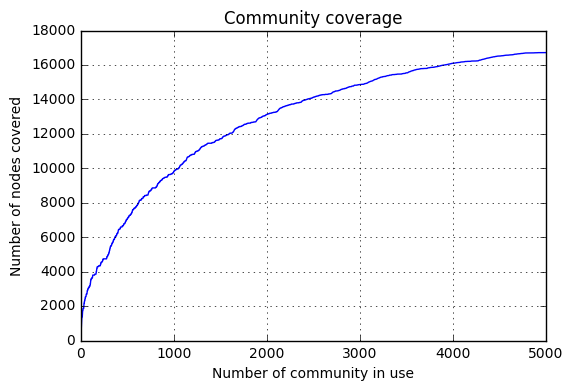

In [29]:
# Coverage for communites in the graph
# coverage[0] = number of nodes that community_0 covers
# coverage[1] = number of nodes that community_0 and community_1 covers
dummy_set = set()
coverage = []
for i in top_index:
    for nodeid in communities_dict[i]:
        dummy_set.add(nodeid)
    coverage.append(len(dummy_set))
num_comm = sp.linspace(start=1, stop=5000, num=5000, dtype=int)

print(len(num_comm), len(coverage))

# Plot the coverage against the number of community in use
plt.figure()
plt.grid(True)
plt.plot(num_comm, coverage, 'b-')
plt.xlabel('Number of community in use')
plt.ylabel('Number of nodes covered')
plt.title('Community coverage')

In the experiment below, I try to plot the accumulated nodes coverage starting from smaller communities first.

5000 5000


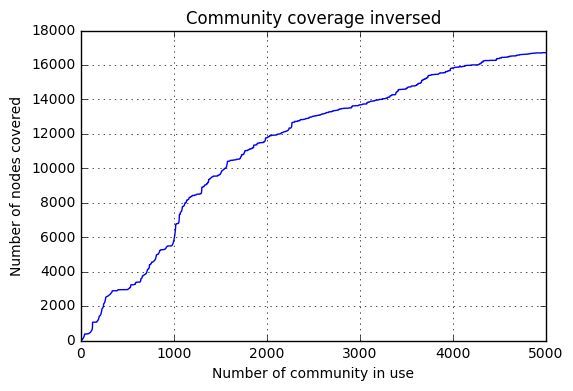

In [30]:
# Coverage for communites in the graph
# coverage[0] = number of nodes that community_0 covers
# coverage[1] = number of nodes that community_0 and community_1 covers
dummy_set = set()
coverage = []
for i in sorted(top_index, reverse=True):
    for nodeid in communities_dict[i]:
        dummy_set.add(nodeid)
    coverage.append(len(dummy_set))
num_comm = sp.linspace(start=1, stop=5000, num=5000, dtype=int)

print(len(num_comm), len(coverage))

# Plot the coverage against the number of community in use
plt.figure()
plt.grid(True)
plt.plot(num_comm, coverage, 'b-')
plt.xlabel('Number of community in use')
plt.ylabel('Number of nodes covered')
plt.title('Community coverage inversed')

The plot shows a quadratic or relationship between the number of nodes covered and the number of community in use. It is very interesting to see such a smooth curve. In this graph, the communities are shorted in decreasing order of their size. This procedure of adding communities to a set can be viewed as a greedy coverage selection algorithm which heuristically select based only on the modular value of the items (community size in this case). This smooth curve is quite interesting, but I have yet understand why. On the other hand, I tried to plot the curve in reversed order (accumulate small communities first), the curve seems... crooked.

In [48]:
# Overlapping test
print(len(set(communities_dict[top_index[0]]) & set(communities_dict[top_index[1]])))

328


In [49]:
# Overlapping test
print(len(set(communities_dict[top_index[0]]) & set(communities_dict[top_index[2]])))

0


In [52]:
# Overlapping test
print(len(set(communities_dict[top_index[1]]) & set(communities_dict[top_index[2]])))

0


In [53]:
# Overlapping test
print(len(set(communities_dict[top_index[2]]) & set(communities_dict[top_index[3]])))

264


In [54]:
len(communities_dict[top_index[2]])

312

In [55]:
len(communities_dict[top_index[3]])

264